# TLS Experiments of LA Q1

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qm.octave import QmOctaveConfig
from quam import QuAM

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
#from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber
import xarray as xr

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q1
TLS_index = 0 # for TLS of interest
dc_flux_index = 0 # for dc line

2024-09-20 11:10:47,804 - qm - INFO     - Starting session: 4f3a78bb-c1e6-4478-ae01-7e7474a7df7d


In [2]:
Analysis = AnalysisHandle("quam_state_q0.json")
machine = Analysis.get_machine()
Experiment = ExperimentHandle(machine)

In [3]:
# initialize Labber-controlled hardware
# get values from QDAC first
#machine = Experiment.set_Labber.get_value_from_QDAC(machine)
# set all Labber settings
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
# set octave to external clock
Experiment.set_octave.set_clock(machine)

------------Octave set to External_10MHz


In [4]:
# set for the qubit
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q0 for (LO, IF) = (6.428 GHz, -50.000 MHz)
------------------------------------- Calibrates r0 for (LO, IF) = (7.312 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


# TLS Characterizations

In [7]:
machine.octaves[0].LO_sources[1].gain = 0
machine = Analysis.set_machine(machine)

In [8]:
TLS_index = 1

## TLS T1 (swap)

In [9]:
%matplotlib qt
# tau_sweep_abs = np.arange(20,2000E3+1,5E4)
tau_sweep_abs = np.arange(20,3000E3+1,1E5)
machine, expt_dataset = Experiment.exp1D.T1.TLS_T1(machine, tau_sweep_abs, qubit_index, TLS_index,
                   n_avg = 1E4, cd_time_qubit = 25E3, cd_time_TLS = 3000E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 1349.92s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0920\2024-09-20_q0t1_tls_T1_swap


Qubit T1: 311.9 [us]


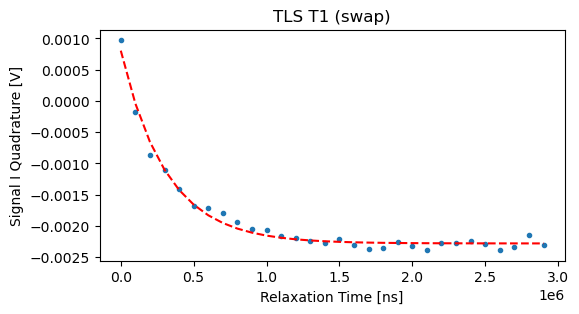

In [11]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')

# TLS Driving Pulses

## set rf_gain for TLS pulse

In [12]:
machine.octaves[0].LO_sources[1].gain = 10
machine = Analysis.set_machine(machine)

## TLS spectroscopy

In [14]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index] + np.arange(50E6,230E6+1,0.5E6)
machine, expt_dataset = Experiment.exp1D.Rabi.TLS_freq(machine, TLS_freq_sweep, qubit_index, TLS_index,
                  n_avg = 5E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2754.18s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0920\2024-09-20_q0t1_tls_spec_2
Execution stopped by user!


In [32]:
%matplotlib qt
plt.plot(expt_dataset['TLS_Frequency'].values, expt_dataset.I.values)


peak frequency:  5293.2 [MHz]


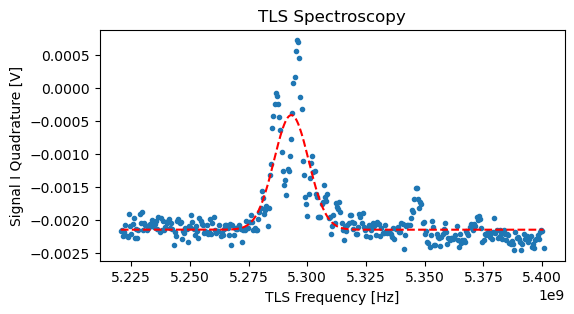

In [34]:
%matplotlib inline
TLS_freq = Analysis.exp1D.peak_fit(expt_dataset, method = "Gaussian", data_process_method = 'I')
# machine.qubits[qubit_index].f_tls[TLS_index] = TLS_freq + 0E6
machine.qubits[qubit_index].f_tls[TLS_index] = 5286E6 + 0E6
machine = Analysis.set_machine(machine)

## TLS rabi

change rf gain of octave

In [36]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 1000 + 0.1, 4)  # in units of ns
machine, expt_dataset = Experiment.exp1D.Rabi.TLS_rabi_length(machine, rabi_duration_sweep, qubit_index, TLS_index,
                      n_avg = 4E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1507.91s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0920\2024-09-20_q0t1_tls_time_rabi_2


rabi_pi_pulse: 68.0 [ns]
pi period: 66.79 [ns]
T2rabi: 352.5 [ns]


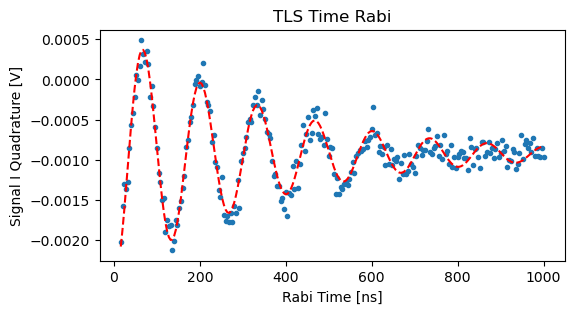

In [38]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, method = "Decay", to_plot = True, data_process_method = 'I')

In [30]:
0.45 * 76 / 78.8

0.434010152284264

In [14]:
machine.qubits[qubit_index].pi_amp_tls[TLS_index]

0.4102827763496144

In [39]:
# machine.qubits[qubit_index].pi_amp_tls[TLS_index] = 0.434010152284264
machine.qubits[qubit_index].pi_length_tls[TLS_index] = 68
machine = Analysis.set_machine(machine)

## TLS Ramsey

In [40]:
%matplotlib qt
ramsey_duration_sweep = np.arange(16, 1500 + 0.1, 16)  # in units of ns
machine, expt_dataset = Experiment.exp1D.Ramsey.TLS_ramsey(machine, ramsey_duration_sweep, qubit_index, TLS_index,
                       n_avg = 5E3, detuning = 2E6, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 709.97s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0920\2024-09-20_q0t1_tls_ramsey


Qubit T2*:  160.2 [ns]
Exponent n =  1.5
Detuning =  2.3 [MHz]


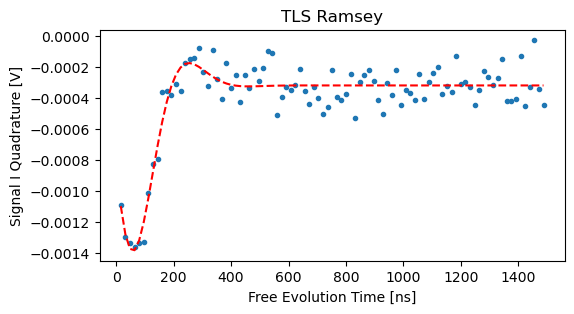

In [42]:
%matplotlib inline
tls_T2star = Analysis.exp1D.ramsey(expt_dataset, data_process_method = 'I')

As a sanity check, run fft, see if there are multiple peaks

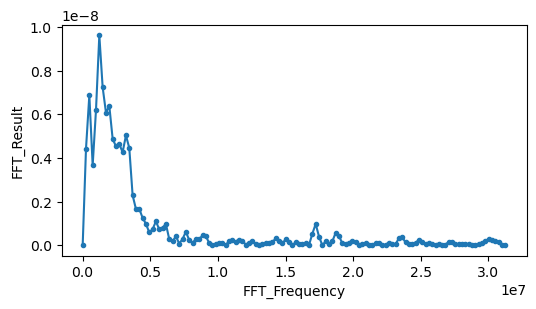

In [43]:
fft_dataset = Analysis.exp1D.fft(expt_dataset, data_process_method = 'I')

## TLS T1 with direct driving

In [45]:
%matplotlib qt
tau_sweep_abs = np.arange(20,3000E3+1,1E5)
machine, expt_dataset = Experiment.exp1D.T1.TLS_T1_drive(machine, tau_sweep_abs, qubit_index, TLS_index,
                     n_avg = 1E4, cd_time_qubit = 25E3, cd_time_TLS = 3000E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 1342.89s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0920\2024-09-20_q0t1_tls_T1_drive


Qubit T1: 342.5 [us]


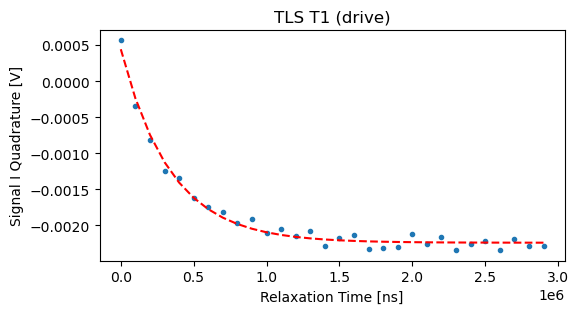

In [47]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')

# TLS Dynamical Decoupling

Qubit T2*:  165.6 [us]
Exponent n =  2.8


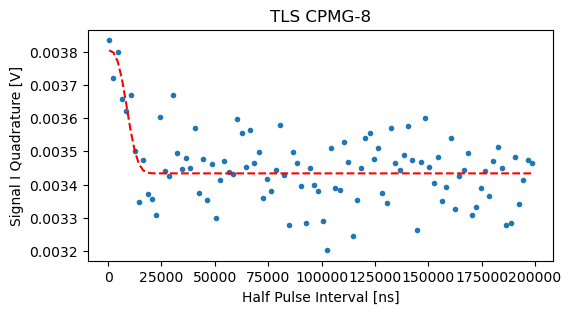

In [66]:
%matplotlib inline
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\06\Data_0612\2024-06-12_q1t0_tls_cpmg8.nc")
# expt_dataset['I'].plot(x=list(expt_dataset.coords.keys())[0], marker = '.')
# plt.title(expt_dataset.attrs['long_name'])
N_CPMG = 8
TLS_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)

## Longer Timescale Decay

### echo

In [48]:
%matplotlib qt
tau_sweep_abs = np.arange(500, 3000E3 + 0.1, 5E4)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_echo(machine, tau_sweep_abs, qubit_index, TLS_index, n_avg = 5E3,
                     cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1343.21s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0920\2024-09-20_q0t1_tls_echo


Qubit T2*:  598.2 [us]
Exponent n =  0.7


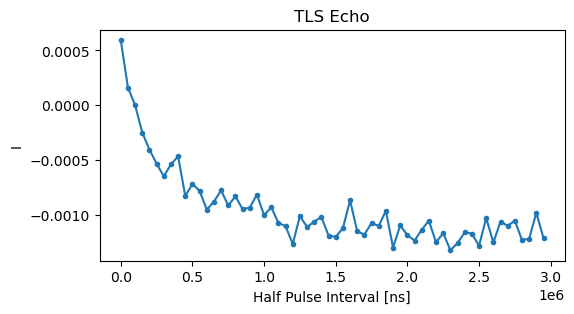

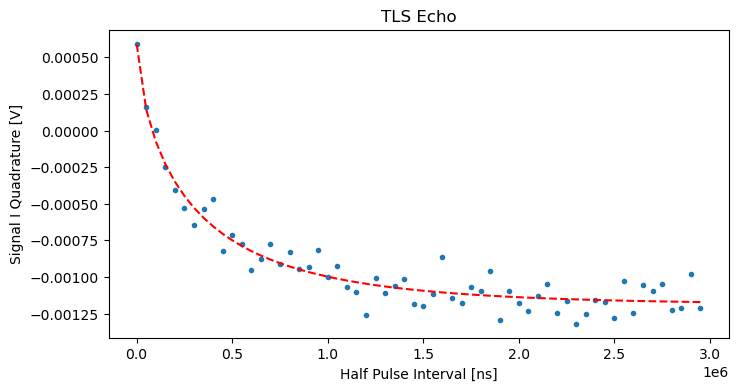

Execution stopped by user!


In [49]:
%matplotlib inline
TLS_T2echo = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau =2)

### CPMG-2

In [50]:
%matplotlib qt
N_CPMG = 2
tau_sweep_abs = np.arange(500, 3000E3 + 0.1, 5E4)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 5E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2227.96s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0920\2024-09-20_q0t1_tls_cpmg2


Qubit T2*:  1276.9 [us]
Exponent n =  0.8


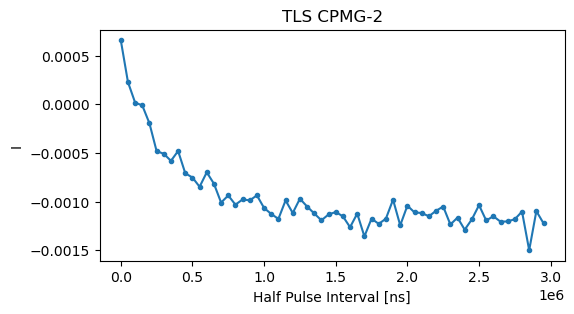

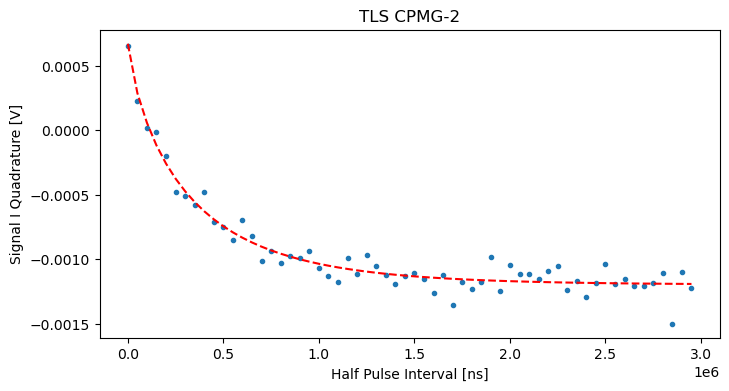

Execution stopped by user!


In [51]:
%matplotlib inline
TLS_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)

### CPMG-8

In [52]:
%matplotlib qt
N_CPMG = 8
tau_sweep_abs = np.arange(500, 3000E3 + 0.1, 5E4)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 5E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 7538.79s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0923\2024-09-23_q0t1_tls_cpmg8


Qubit T2*:  4993.8 [us]
Exponent n =  0.9


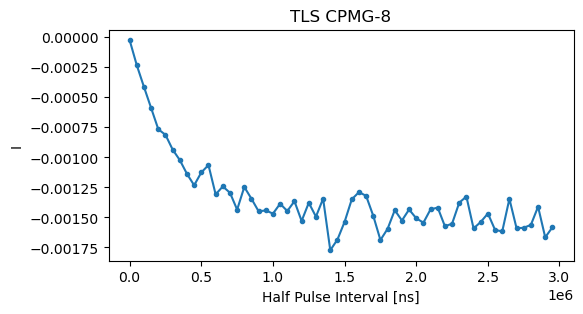

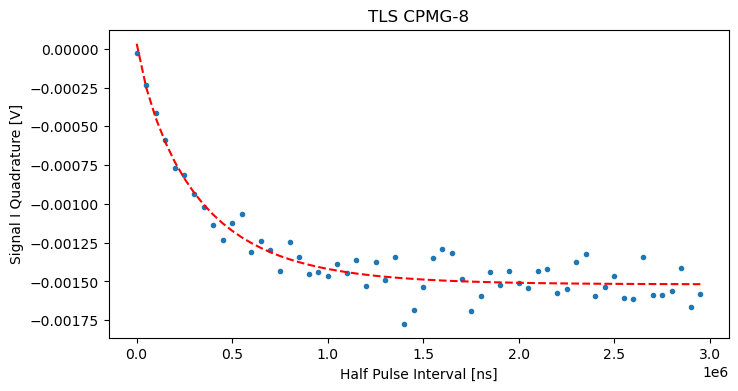

Execution stopped by user!


In [53]:
%matplotlib inline
TLS_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)

## Shorter Timescale Dynamics

In [54]:
## Set values beforehand so we do not need to change it every time leading to potential mess ups

tau_sweep_abs = np.arange(20, 10E3 + 0.1, 20)  # in units of ns
n_avg = 5E3
cd_time_qubit = 25E3
cd_time_TLS = 1500E3

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3864.41s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3864.46s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0923\2024-09-23_q0t1_tls_cpmg2
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3914.87s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3914.91s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0923\2024-09-23_q0t1_tls_cpmg4
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3965.33s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3965.38s
----------saved to Z:\QM_Data_DF5\2024\09\Data_0923\2024-09-23_q0t1_tls_cpmg6
Progress: [##################################################] 100.0% (n=5000/5000.0) --

<Figure size 600x300 with 0 Axes>

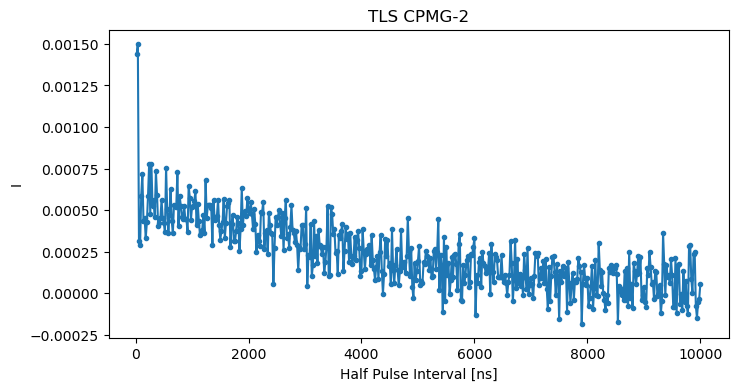

<Figure size 800x400 with 0 Axes>

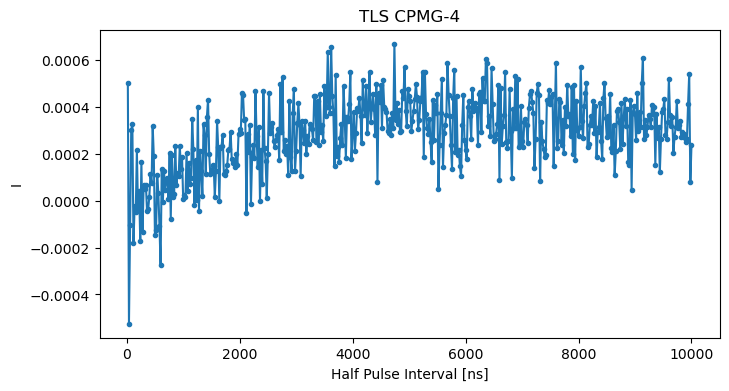

<Figure size 800x400 with 0 Axes>

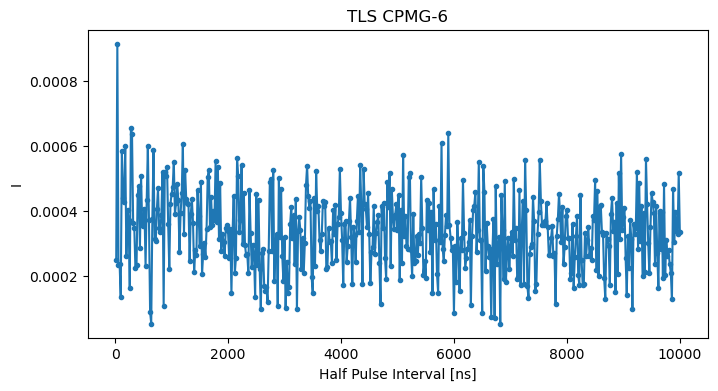

<Figure size 800x400 with 0 Axes>

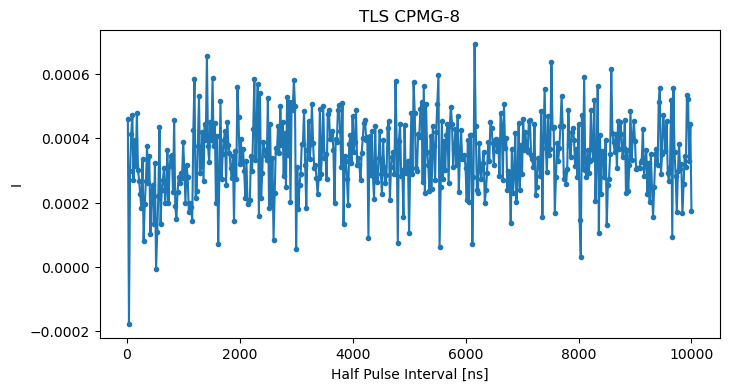

<Figure size 800x400 with 0 Axes>

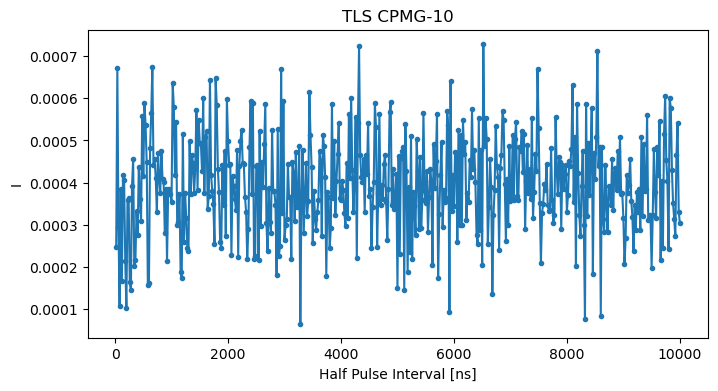

<Figure size 800x400 with 0 Axes>

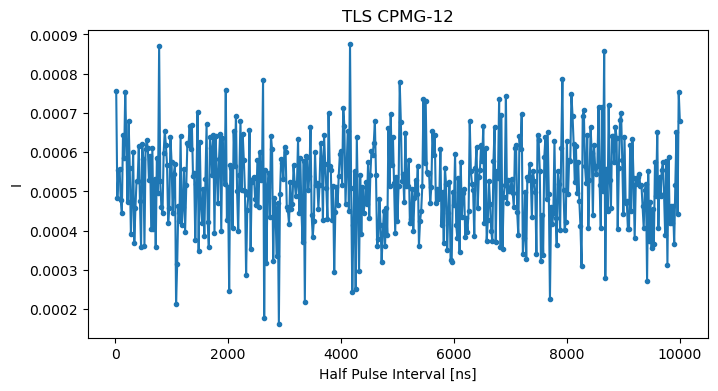

In [55]:
N_CPMG_sweep = np.arange(2, 12 + 0.1, 2)
tau_sweep_abs = tau_sweep_abs
for N in N_CPMG_sweep:
    N = int(N)
    machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-2

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 7856.31s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 7856.37s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 7856.41s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 7856.45s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 7856.49s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0613\2024-06-13_q1t0_tls_cpmg2


<Figure size 800x400 with 0 Axes>

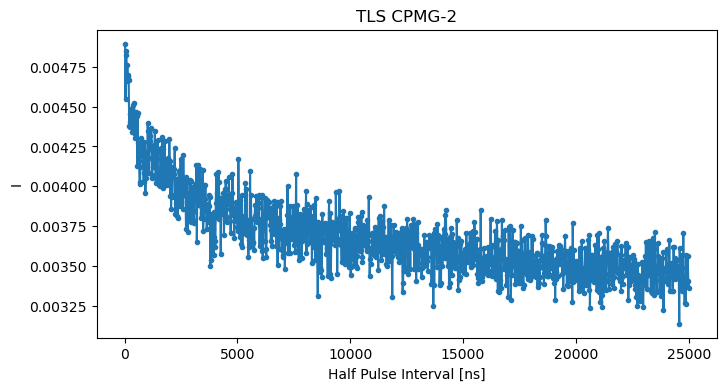

In [160]:
%matplotlib inline
N_CPMG = 2
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-4

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 8107.09s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 8107.14s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 8107.18s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 8107.22s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0613\2024-06-13_q1t0_tls_cpmg4


<Figure size 800x400 with 0 Axes>

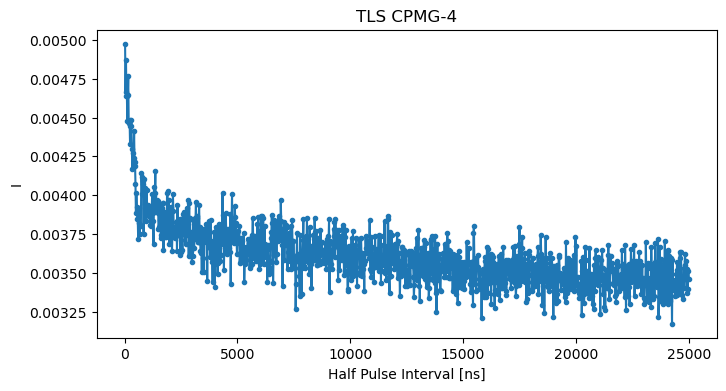

In [161]:
%matplotlib inline
N_CPMG = 4
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

In [162]:
# %matplotlib inline
# expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0520\2024-05-20_q1t1_tls_cpmg4.nc")
# expt_dataset['I'].plot(x=list(expt_dataset.coords.keys())[0], marker = '.')
# plt.title(expt_dataset.attrs['long_name'])

### CPMG-6

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 8358.09s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 8358.13s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 8358.17s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 8358.20s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0613\2024-06-13_q1t0_tls_cpmg6


<Figure size 800x400 with 0 Axes>

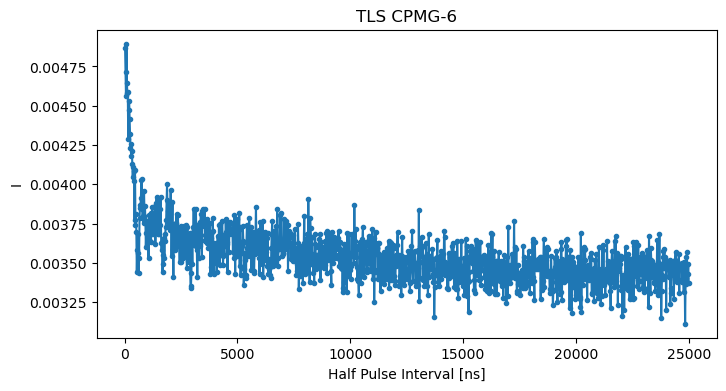

In [163]:
%matplotlib inline
N_CPMG = 6
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-8

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 95.19s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 95.24s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0614\2024-06-14_q1t0_tls_cpmg8_4


<Figure size 800x400 with 0 Axes>

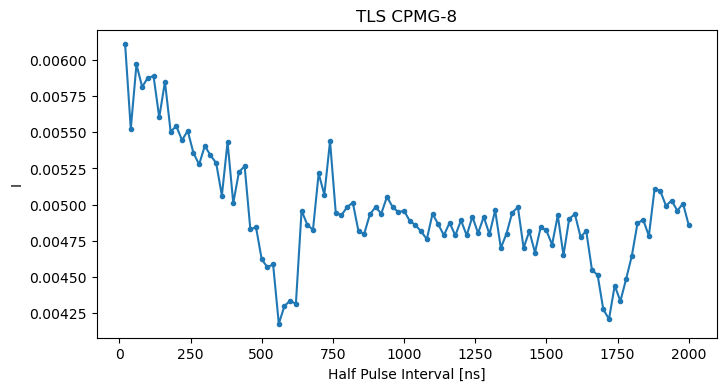

In [7]:
%matplotlib inline
N_CPMG = 8
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

In [165]:
# %matplotlib inline
# expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\06\Data_0607\2024-06-07_q1t0_tls_cpmg8_3.nc")
# expt_dataset['I'].plot(x=list(expt_dataset.coords.keys())[0], marker = '.')
# plt.title(expt_dataset.attrs['long_name'])

### CPMG-10

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 8859.72s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 8859.78s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 8859.82s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0613\2024-06-13_q1t0_tls_cpmg10


<Figure size 800x400 with 0 Axes>

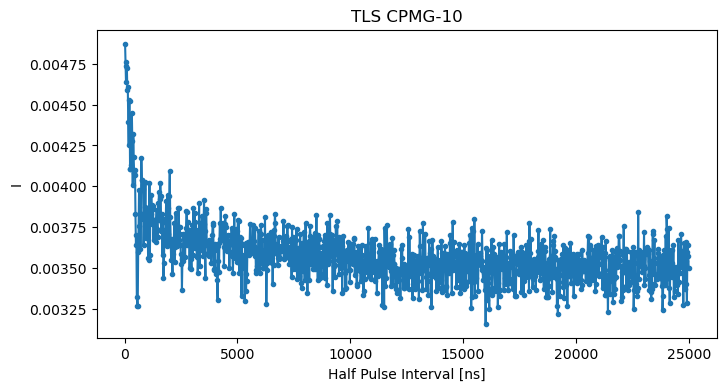

In [166]:
%matplotlib inline
N_CPMG = 10
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-12

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 9110.77s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 9110.81s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 9110.85s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0613\2024-06-13_q1t0_tls_cpmg12


<Figure size 800x400 with 0 Axes>

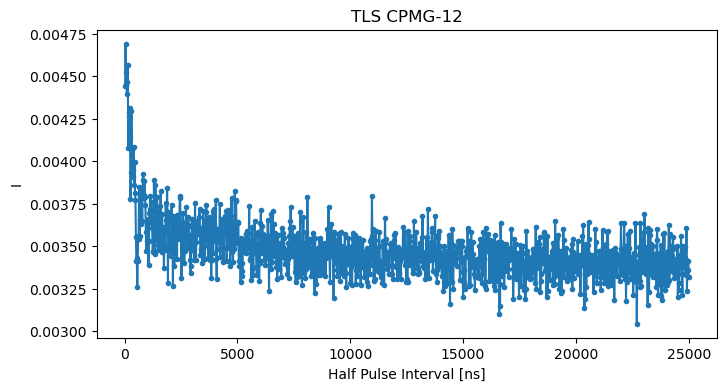

In [167]:
%matplotlib inline
N_CPMG = 12
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-14

In [ ]:
%matplotlib inline
N_CPMG = 14
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-16

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 9612.59s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 9612.64s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 9612.68s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0613\2024-06-13_q1t0_tls_cpmg16


<Figure size 800x400 with 0 Axes>

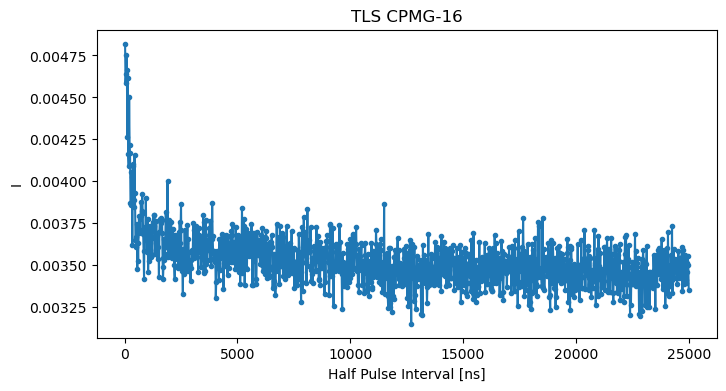

In [168]:
%matplotlib inline
N_CPMG = 16
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

Text(0.5, 1.0, 'TLS CPMG-16')

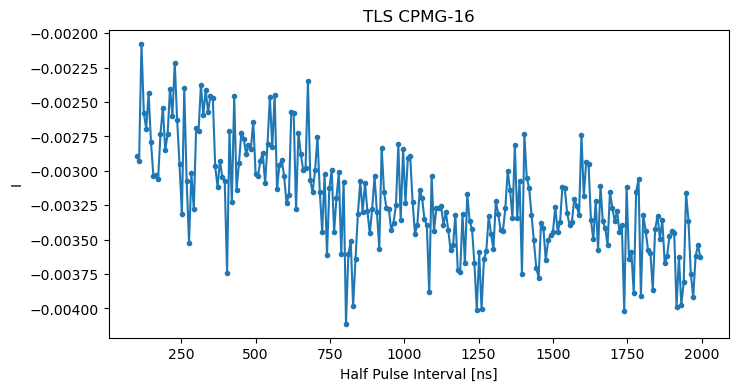

In [169]:
# %matplotlib inline
# expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0520\2024-05-20_q1t1_tls_cpmg16.nc")
# expt_dataset['I'].plot(x=list(expt_dataset.coords.keys())[0], marker = '.')
# plt.title(expt_dataset.attrs['long_name'])

### CPMG-18

In [ ]:
%matplotlib inline
N_CPMG = 18
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-20

In [ ]:
%matplotlib inline
N_CPMG = 20
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-22

In [ ]:
%matplotlib inline
N_CPMG = 22
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-24

In [ ]:
%matplotlib inline
N_CPMG = 24
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-26

In [ ]:
%matplotlib inline
N_CPMG = 26
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-28

In [ ]:
%matplotlib inline
N_CPMG = 28
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-30

In [ ]:
%matplotlib inline
N_CPMG = 30
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-32

In [ ]:
%matplotlib inline
N_CPMG = 32
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

### CPMG-40

In [38]:
%matplotlib qt
N_CPMG = 40
tau_sweep_abs = tau_sweep_abs
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = n_avg, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd_time_TLS, live_plot = False)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 937.50s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 937.53s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0521\2024-05-21_q1t1_tls_cpmg40
Execution stopped by user!


### Rabi CPMG

In [21]:
cd_time_TLS = np.arange(100E3, 2000E3 + 0.1, 100E3)
cd_time_TLS = cd_time_TLS.astype(int)
type(cd_time_TLS[0])

numpy.int32

In [53]:
cd_time_TLS = np.arange(100E3, 2000E3 + 0.1, 100E3)
cd_time_TLS = cd_time_TLS.astype(float)
a = cd_time_TLS[0].item()
type(a)

float

In [55]:
%matplotlib qt

cd_time_qubit = 20E3
# cd_time_TLS = 200E3

N_CPMG_sweep = np.arange(2, 32 + 0.1, 2) 

# tau = [156, 568] # in units of ns
tau = np.arange(540, 592  + 0.1, 4)
cd_time_TLS = np.arange(100E3, 2000E3 + 0.1, 100E3)
cd_time_TLS = cd_time_TLS.astype(float)

for t in tau:
    for cd in cd_time_TLS:
        cd = cd.item()
        machine, expt_dataset = Experiment.exp1D.Rabi.TLS_CPMG_Rabi(machine, N_CPMG_sweep, t, qubit_index, TLS_index, 
                         n_avg = 10E3, cd_time_qubit = cd_time_qubit, cd_time_TLS = cd)


Progress: [##################################################] 100.0% (n=16/16) --> elapsed time: 1718722460.60s
Elapsed duration 50.226083 s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0618\2024-06-18_q1t0_tls_cpmg_rabi540.0ns
Progress: [##################################################] 100.0% (n=16/16) --> elapsed time: 1718722525.06s
Elapsed duration 64.259471 s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0618\2024-06-18_q1t0_tls_cpmg_rabi540.0ns_2
Progress: [##################################################] 100.0% (n=16/16) --> elapsed time: 1718722607.95s
Elapsed duration 82.663223 s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0618\2024-06-18_q1t0_tls_cpmg_rabi540.0ns_3
Progress: [##################################################] 100.0% (n=16/16) --> elapsed time: 1718722705.86s
Elapsed duration 97.724957 s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0618\2024-06-18_q1t0_tls_cpmg_rabi540.0ns_4
Progress: [##################################################] 100.0% 

KeyboardInterrupt: 